In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In this notebook, we will build a Multilayer-Perceptron (MLP) for identifying text in an image.


Here we'll use the MNIST dataset which consists of greyscale handwritten digits. 
Each image is 28x28 pixels, you can see a sample imgae in the below

<br/>
<img src='../images/mnist.png' width="500" />
<br/>

First we will download MNIST dataset, which is provided through [``torchvision``](https://pytorch.org/vision/stable/index.html) package.

### Loading MNIST dataset into train-val-test set

In [2]:
import torchvision.transforms as transforms 
import torchvision.datasets as datasets

We usually use various random transformation for training-dataset to get various augmentations.

However, for test-dataset we do not use any random transformations.

Random transformations are provided through [``torchvision.transforms``](https://pytorch.org/vision/stable/transforms.html) package.

**train-test-transform**

In [3]:
# Define a transform to normalize the data
train_transform = transforms.Compose([transforms.RandomResizedCrop((28, 28)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [4]:
train_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=train_transform)

# val-dataset refers to the same dataset as train-dataset, however, while validating the model's performance
# we do not use any random-transformation
val_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=test_transform)

test_dataset = datasets.MNIST(root='../data', train=False, download=True, transform=test_transform)

**Separating train-set into train & validation set**
- Let's set validation set size as 20%, therefore, we will be using 80% of training set for training 
    the neural network
- Validating a model while training w.r.t a validation-set can help us from overfitting
- Validation-set works as an alternative to the actual test-set, as it is assumed that while training 
    we do not have any access to the test-set 

In [5]:
train_set_size = len(train_dataset)
print('train-set-size: {}'.format(train_set_size))

train-set-size: 60000


In [6]:
all_indices = list(range(train_set_size))
print('len(all_indices): '.format(len(all_indices)))

np.random.shuffle(all_indices)

val_size = int(0.2 * len(all_indices))
train_size = len(all_indices) - val_size
print('val-size: {} train-size: {}'.format(val_size, train_size))

val_indices = all_indices[:val_size]
train_indices = all_indices[val_size:]

print('len(train_indices): {} len(val_indices): {}'.format(len(train_indices), len(val_indices)))

len(all_indices): 
val-size: 12000 train-size: 48000
len(train_indices): 48000 len(val_indices): 12000


In [7]:
from torch.utils.data import SubsetRandomSampler

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, 
                                           sampler=SubsetRandomSampler(train_indices), num_workers=4, 
                                           pin_memory=True)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64,
                                        sampler=SubsetRandomSampler(val_indices), num_workers=4,
                                        pin_memory=True)


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True,
                                          num_workers=4, pin_memory=True)

In [9]:
train_batch, _ = next(iter(train_loader))
val_batch, _ = next(iter(val_loader))
test_batch, _ = next(iter(test_loader))

In [10]:
import torchvision

train_grid_img = torchvision.utils.make_grid(train_batch, nrow=8)
val_grid_img = torchvision.utils.make_grid(val_batch, nrow=8)
test_grid_img = torchvision.utils.make_grid(test_batch, nrow=8)

#### Display a batch of training data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


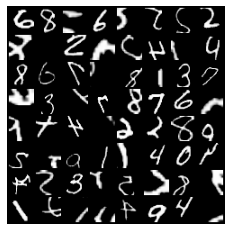

In [11]:
plt.imshow(train_grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

#### Display a batch of validation data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


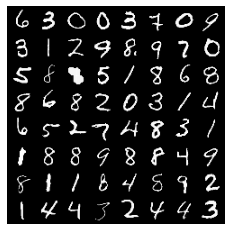

In [12]:
plt.imshow(val_grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

#### Display a batch of test data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


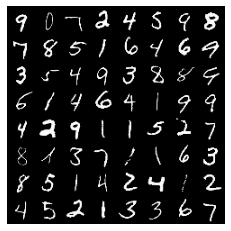

In [13]:
plt.imshow(test_grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [14]:
!python --version

Python 3.7.7


## MLP training

In [15]:
import torch
import torch.nn as nn
from torch.nn import DataParallel
import time
import torch.optim as optim

from typing import Tuple, Any, List

def trainCls(model: nn.Module, train_loader: torch.utils.data.DataLoader, 
             val_loader: torch.utils.data.DataLoader, lr: float=0.1, epochs: int=100, 
             momentum: float=0.9, weight_decay: float=5e-4, 
             checkpoint: str='./checkpoint') -> Tuple[nn.Module, List, List, List, List]:
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('device: {}'.format(device))
    
    model.to(device) # loading model to device

    if torch.cuda.device_count() > 1:
        if not isinstance(model, DataParallel):
            model = DataParallel(model) # if more that one gpu is available,
                                        # then wrap model with DataParallel,
                                        # so that it can be trained on multiple gpus
    
    model.to(device) # load model to device

    criterion = nn.CrossEntropyLoss() # loss-function for classification
    
    # optimizer is used to optime the model parameters while doing back-propagation
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    start = time.time()
    best_acc = 0.0
    
    trainLoss_, valLoss_ = list(), list()
    trainAcc_, valAcc_ = list(), list()
    
    start_epoch = 0

    for epoch in range(start_epoch, epochs):
        model.train()
        train_loss, train_acc = 0.0, 0.0
        for _, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            model.zero_grad()
            
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * data.size(0)
            _, predicted = output.max(1)
            train_acc += predicted.eq(target).sum().item()
        
        train_loss, train_acc = train_loss/len(train_loader.sampler), train_acc/len(train_loader.sampler)
        trainLoss_.append(train_loss)
        trainAcc_.append(train_acc)

        val_loss, val_acc = 0.0, 0.0
        model.eval()
        for _, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)
            
            val_loss += loss.item() * data.size(0)
            _, predicted = output.max(1)
            val_acc += predicted.eq(target).sum().item()
        
        val_loss, val_acc = val_loss/len(val_loader.sampler), val_acc/len(val_loader.sampler)
        valLoss_.append(val_loss)
        valAcc_.append(val_acc)

        if val_acc > best_acc:
            print('Epoch: {} val accuracy improved: {:0.4f} ==> {:0.4f}'.format(epoch+1, best_acc, val_acc))
            best_acc = val_acc

            try:
                state_dict = model.state_dict()
            except:
                state_dict = model.module.state_dict()

            torch.save(state_dict, checkpoint)

        print('Epoch: [{}/{}] train_acc: {:0.4f} val_acc: {:0.4f} train_loss: {:0.4f} val_loss: {:0.4f}'.format(epoch+1, epochs, train_acc, val_acc, train_loss, val_loss))

    total_time = time.time() - start
    print('time: {:0.0f}m {:0.0f}s'.format((total_time//60), (total_time%60)))
    
    # loading model's best saved weight
    try:
        model.load_state_dict(torch.load(checkpoint, map_location=device))
    except:
        model.module.load_state_dict(torch.load(checkpoint, map_location=device))

    return model, trainLoss_, valLoss_, trainAcc_, valAcc_

## MLP evaluation

In [16]:
def testCls(model: nn.Module, test_loader: torch.utils.data.DataLoader, 
            checkpoint: str) -> Tuple[nn.Module, float, float]:
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('device: {}'.format(device))
    
    model.to(device) # loading model to device

    if torch.cuda.device_count() > 1:
        if not isinstance(model, DataParallel):
            model = DataParallel(model) # if more that one gpu is available,
                                        # then wrap model with DataParallel,
                                        # so that it can be trained on multiple gpus
    
    model.to(device) # load model to device

    criterion = nn.CrossEntropyLoss() # loss-function for classification
    
    # loading model's saved weight
    try:
        model.load_state_dict(torch.load(checkpoint, map_location=device))
    except:
        model.module.load_state_dict(torch.load(checkpoint, map_location=device))

    model.eval()
    
    test_loss, test_acc = 0.0, 0.0
    for _, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)

        data = data.to(memory_format=torch.contiguous_format)

        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)
        _, predicted = output.max(1)
        test_acc += predicted.eq(target).sum().item()

    test_loss, test_acc = test_loss/len(test_loader.sampler), test_acc/len(test_loader.sampler)

    print('test_loss: {:0.4f} \t test_acc: {:0.4f}'.format(test_loss, test_acc))

    return model, test_loss, test_acc

## Defining MLP with PyTorch (Type - 1)

In [5]:
import torch.nn as nn

In [6]:
class MLP(nn.Module):
    
    def __init__(self, in_features: int=784, hidden_features: int=256, out_features: int=10) -> None:
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(in_features=in_features, out_features=hidden_features)
        self.fc2 = nn.Linear(in_features=hidden_features, out_features=hidden_features)
        self.fc3 = nn.Linear(in_features=hidden_features, out_features=out_features)
        
        self.relu = nn.ReLU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), -1)
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        return self.fc3(out)

### Training MLP (Type - 1) with Pytorch

In [7]:
model = MLP()
print(model, '\n\n')

MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
) 




In [20]:
# momentum, weight-decay will be discussed in the later classes

model, train_loss, val_loss, train_acc, val_acc = trainCls(model, train_loader, val_loader, 
                                                           lr=0.002, epochs=100, momentum=0.9, 
                                        weight_decay=5e-4, checkpoint='mlp_type_1_best_model.pth')

device: cuda:0
Epoch: 1 val accuracy improved: 0.0000 ==> 0.5646
Epoch: [1/100] train_acc: 0.2719 val_acc: 0.5646 train_loss: 2.0999 val_loss: 1.4764
Epoch: 2 val accuracy improved: 0.5646 ==> 0.6973
Epoch: [2/100] train_acc: 0.4061 val_acc: 0.6973 train_loss: 1.7997 val_loss: 1.1030
Epoch: 3 val accuracy improved: 0.6973 ==> 0.7928
Epoch: [3/100] train_acc: 0.5025 val_acc: 0.7928 train_loss: 1.5196 val_loss: 0.8331
Epoch: 4 val accuracy improved: 0.7928 ==> 0.8143
Epoch: [4/100] train_acc: 0.5591 val_acc: 0.8143 train_loss: 1.3456 val_loss: 0.6794
Epoch: [5/100] train_acc: 0.5989 val_acc: 0.8078 train_loss: 1.2247 val_loss: 0.6307
Epoch: 6 val accuracy improved: 0.8143 ==> 0.8523
Epoch: [6/100] train_acc: 0.6255 val_acc: 0.8523 train_loss: 1.1398 val_loss: 0.5204
Epoch: [7/100] train_acc: 0.6418 val_acc: 0.8498 train_loss: 1.0796 val_loss: 0.5014
Epoch: [8/100] train_acc: 0.6545 val_acc: 0.8417 train_loss: 1.0461 val_loss: 0.5128
Epoch: [9/100] train_acc: 0.6673 val_acc: 0.8421 train_

Epoch: [83/100] train_acc: 0.7861 val_acc: 0.9407 train_loss: 0.6454 val_loss: 0.1902
Epoch: [84/100] train_acc: 0.7853 val_acc: 0.9467 train_loss: 0.6481 val_loss: 0.1713
Epoch: [85/100] train_acc: 0.7862 val_acc: 0.9377 train_loss: 0.6437 val_loss: 0.1849
Epoch: [86/100] train_acc: 0.7853 val_acc: 0.9419 train_loss: 0.6425 val_loss: 0.1826
Epoch: [87/100] train_acc: 0.7879 val_acc: 0.9442 train_loss: 0.6384 val_loss: 0.1762
Epoch: [88/100] train_acc: 0.7859 val_acc: 0.9481 train_loss: 0.6420 val_loss: 0.1671
Epoch: [89/100] train_acc: 0.7880 val_acc: 0.9490 train_loss: 0.6406 val_loss: 0.1651
Epoch: [90/100] train_acc: 0.7851 val_acc: 0.9470 train_loss: 0.6400 val_loss: 0.1739
Epoch: [91/100] train_acc: 0.7854 val_acc: 0.9412 train_loss: 0.6416 val_loss: 0.1878
Epoch: [92/100] train_acc: 0.7869 val_acc: 0.9471 train_loss: 0.6347 val_loss: 0.1722
Epoch: [93/100] train_acc: 0.7864 val_acc: 0.9402 train_loss: 0.6385 val_loss: 0.1912
Epoch: [94/100] train_acc: 0.7887 val_acc: 0.9470 trai

In [21]:
model, test_loss, test_acc = testCls(model, test_loader, checkpoint='mlp_type_1_best_model.pth')

device: cuda:0
test_loss: 0.1457 	 test_acc: 0.9523


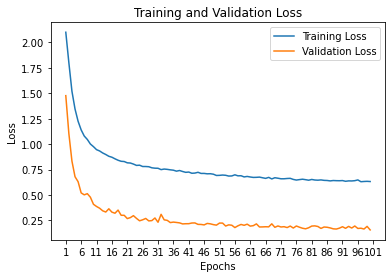

In [22]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

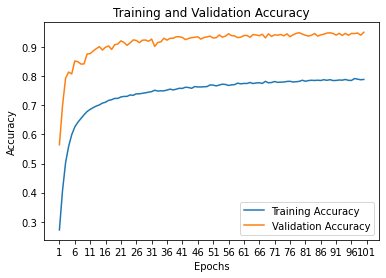

In [23]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# Add in a title and axes labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

## Defining MLP with nn.Sequential() (Type - 2)

In [8]:
class MLP(nn.Module):
    
    def __init__(self, in_features: int=784, hidden_features: int=256, out_features: int=10) -> None:
        super(MLP, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=out_features)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), -1)
        return self.fc(x)

### Training MLP (Type - 2) with Pytorch

In [9]:
model = MLP()
print(model, '\n\n')

MLP(
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
) 




In [26]:
# momentum, weight-decay will be discussed in the later classes

model, train_loss, val_loss, train_acc, val_acc = trainCls(model, train_loader, val_loader, 
                                                           lr=0.002, epochs=100, momentum=0.9, 
                                        weight_decay=5e-4, checkpoint='mlp_type_2_best_model.pth')

device: cuda:0
Epoch: 1 val accuracy improved: 0.0000 ==> 0.5968
Epoch: [1/100] train_acc: 0.2628 val_acc: 0.5968 train_loss: 2.1182 val_loss: 1.4891
Epoch: 2 val accuracy improved: 0.5968 ==> 0.7280
Epoch: [2/100] train_acc: 0.4048 val_acc: 0.7280 train_loss: 1.7949 val_loss: 1.0773
Epoch: 3 val accuracy improved: 0.7280 ==> 0.8087
Epoch: [3/100] train_acc: 0.5102 val_acc: 0.8087 train_loss: 1.5060 val_loss: 0.8289
Epoch: [4/100] train_acc: 0.5660 val_acc: 0.7967 train_loss: 1.3264 val_loss: 0.7403
Epoch: 5 val accuracy improved: 0.8087 ==> 0.8318
Epoch: [5/100] train_acc: 0.5990 val_acc: 0.8318 train_loss: 1.2179 val_loss: 0.6085
Epoch: 6 val accuracy improved: 0.8318 ==> 0.8578
Epoch: [6/100] train_acc: 0.6257 val_acc: 0.8578 train_loss: 1.1361 val_loss: 0.5554
Epoch: [7/100] train_acc: 0.6432 val_acc: 0.8393 train_loss: 1.0885 val_loss: 0.5268
Epoch: 8 val accuracy improved: 0.8578 ==> 0.8847
Epoch: [8/100] train_acc: 0.6557 val_acc: 0.8847 train_loss: 1.0391 val_loss: 0.4204
Epoch

Epoch: 81 val accuracy improved: 0.9486 ==> 0.9504
Epoch: [81/100] train_acc: 0.7836 val_acc: 0.9504 train_loss: 0.6512 val_loss: 0.1658
Epoch: [82/100] train_acc: 0.7832 val_acc: 0.9457 train_loss: 0.6501 val_loss: 0.1763
Epoch: [83/100] train_acc: 0.7844 val_acc: 0.9493 train_loss: 0.6508 val_loss: 0.1731
Epoch: [84/100] train_acc: 0.7873 val_acc: 0.9458 train_loss: 0.6403 val_loss: 0.1763
Epoch: [85/100] train_acc: 0.7852 val_acc: 0.9347 train_loss: 0.6429 val_loss: 0.2000
Epoch: [86/100] train_acc: 0.7833 val_acc: 0.9441 train_loss: 0.6447 val_loss: 0.1883
Epoch: [87/100] train_acc: 0.7827 val_acc: 0.9407 train_loss: 0.6505 val_loss: 0.1879
Epoch: [88/100] train_acc: 0.7851 val_acc: 0.9473 train_loss: 0.6505 val_loss: 0.1665
Epoch: [89/100] train_acc: 0.7871 val_acc: 0.9426 train_loss: 0.6432 val_loss: 0.1936
Epoch: 90 val accuracy improved: 0.9504 ==> 0.9510
Epoch: [90/100] train_acc: 0.7849 val_acc: 0.9510 train_loss: 0.6421 val_loss: 0.1700
Epoch: [91/100] train_acc: 0.7858 val_

In [27]:
model, test_loss, test_acc = testCls(model, test_loader, checkpoint='mlp_type_2_best_model.pth')

device: cuda:0
test_loss: 0.1538 	 test_acc: 0.9552


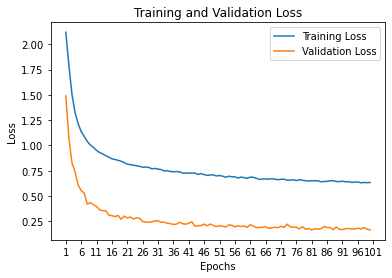

In [28]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

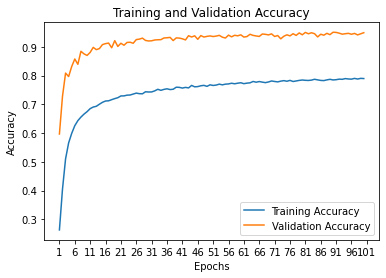

In [29]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# Add in a title and axes labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

## Defining MLP with Dropout (Type - 3)

In [10]:
class MLP(nn.Module):
    
    def __init__(self, in_features: int=784, hidden_features: int=256, out_features: int=10, 
                 rate: float=0.4) -> None:
        super(MLP, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Dropout(p=rate),
            nn.Linear(in_features=hidden_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Dropout(p=rate),
            nn.Linear(in_features=hidden_features, out_features=out_features)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), -1)
        return self.fc(x)

### Training MLP (Type - 3) with Pytorch

In [11]:
model = MLP()
print(model, '\n\n')

MLP(
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=256, out_features=10, bias=True)
  )
) 




In [32]:
# momentum, weight-decay will be discussed in the later classes

model, train_loss, val_loss, train_acc, val_acc = trainCls(model, train_loader, val_loader, 
                                                           lr=0.002, epochs=100, momentum=0.9, 
                                        weight_decay=5e-4, checkpoint='mlp_type_3_best_model.pth')

device: cuda:0
Epoch: 1 val accuracy improved: 0.0000 ==> 0.5204
Epoch: [1/100] train_acc: 0.2186 val_acc: 0.5204 train_loss: 2.1839 val_loss: 1.6473
Epoch: 2 val accuracy improved: 0.5204 ==> 0.7068
Epoch: [2/100] train_acc: 0.3296 val_acc: 0.7068 train_loss: 1.9767 val_loss: 1.2965
Epoch: 3 val accuracy improved: 0.7068 ==> 0.7288
Epoch: [3/100] train_acc: 0.3984 val_acc: 0.7288 train_loss: 1.8121 val_loss: 1.1139
Epoch: 4 val accuracy improved: 0.7288 ==> 0.7790
Epoch: [4/100] train_acc: 0.4445 val_acc: 0.7790 train_loss: 1.6765 val_loss: 0.9398
Epoch: 5 val accuracy improved: 0.7790 ==> 0.7895
Epoch: [5/100] train_acc: 0.4771 val_acc: 0.7895 train_loss: 1.5696 val_loss: 0.8259
Epoch: 6 val accuracy improved: 0.7895 ==> 0.8295
Epoch: [6/100] train_acc: 0.5005 val_acc: 0.8295 train_loss: 1.4935 val_loss: 0.7439
Epoch: [7/100] train_acc: 0.5224 val_acc: 0.8179 train_loss: 1.4303 val_loss: 0.6619
Epoch: 8 val accuracy improved: 0.8295 ==> 0.8557
Epoch: [8/100] train_acc: 0.5344 val_acc

Epoch: [81/100] train_acc: 0.6734 val_acc: 0.9237 train_loss: 0.9819 val_loss: 0.2661
Epoch: [82/100] train_acc: 0.6697 val_acc: 0.9278 train_loss: 0.9880 val_loss: 0.2518
Epoch: [83/100] train_acc: 0.6707 val_acc: 0.9274 train_loss: 0.9879 val_loss: 0.2508
Epoch: [84/100] train_acc: 0.6706 val_acc: 0.9287 train_loss: 0.9856 val_loss: 0.2505
Epoch: [85/100] train_acc: 0.6713 val_acc: 0.9250 train_loss: 0.9826 val_loss: 0.2561
Epoch: [86/100] train_acc: 0.6713 val_acc: 0.9307 train_loss: 0.9839 val_loss: 0.2492
Epoch: 87 val accuracy improved: 0.9315 ==> 0.9356
Epoch: [87/100] train_acc: 0.6730 val_acc: 0.9356 train_loss: 0.9808 val_loss: 0.2290
Epoch: [88/100] train_acc: 0.6745 val_acc: 0.9230 train_loss: 0.9822 val_loss: 0.2636
Epoch: [89/100] train_acc: 0.6746 val_acc: 0.9292 train_loss: 0.9760 val_loss: 0.2353
Epoch: [90/100] train_acc: 0.6680 val_acc: 0.9297 train_loss: 0.9888 val_loss: 0.2435
Epoch: [91/100] train_acc: 0.6733 val_acc: 0.9278 train_loss: 0.9768 val_loss: 0.2383
Epo

In [33]:
model, test_loss, test_acc = testCls(model, test_loader, checkpoint='mlp_type_3_best_model.pth')

device: cuda:0
test_loss: 0.2080 	 test_acc: 0.9399


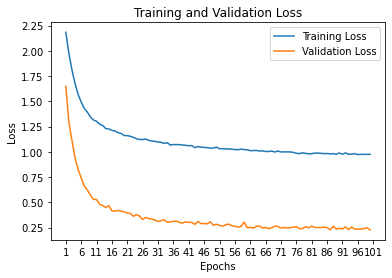

In [34]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

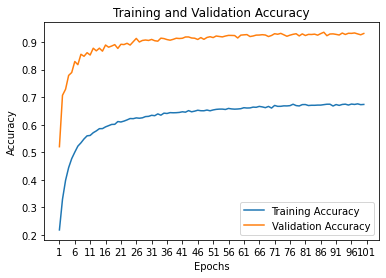

In [35]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# Add in a title and axes labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()